In [1]:
import pickle
from os.path import join
import numpy as np
import warnings
from scipy.stats import gaussian_kde
import seaborn as sns
from scipy.interpolate import InterpolatedUnivariateSpline, UnivariateSpline
from settings import *
from tools import get_mids
from matplotlib.colors import LogNorm
from scipy.special import erf
from scipy.stats import norm
from scipy.interpolate import RegularGridInterpolator


Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


In [2]:
# plot settings
matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use(join(BASEPATH, "style.mplstyle"))
colorlist = plt.rcParams["axes.prop_cycle"].by_key()["color"]
warnings.filterwarnings("ignore")


In [3]:
# Calculate energy smearing
# the columns are:
# 0                    1                    2                3
# log10(E_nu/GeV)_min  log10(E_nu/GeV)_max  Dec_nu_min[deg]  Dec_nu_max[deg]
# 4                 5                 6             7
# log10(E/GeV)_min  log10(E/GeV)_max  PSF_min[deg]  PSF_max[deg]
# 8                9                10
# AngErr_min[deg]  AngErr_max[deg]  Fractional_Counts
public_data_hist = np.genfromtxt(join(BASEPATH, "resources/IC86_II_smearing.csv"), skip_header=1)

log_sm_emids = (public_data_hist[:, 0] + public_data_hist[:, 1]) / 2.0
log_sm_ereco_mids = (public_data_hist[:, 4] + public_data_hist[:, 5]) / 2.0
fractional_event_counts = public_data_hist[:, 10]


In [4]:
# define a mask for the upgoing and horizontal region
# these are the declination bins (lower and upper edges)
print(np.unique(public_data_hist[:, 2]), np.unique(public_data_hist[:, 3])) 
# down-going (=South): -90 -> -10 deg
# horizontal: -10 -> 10 deg
# up-going (=North): 10 -> 90 deg
dec_mask = public_data_hist[:, 2] >= -10.

[-90. -10.  10.] [-10.  10.  90.]


In [5]:
# energy resolution averaged over the full sky
e_ereco_kdes_full = gaussian_kde(
    (log_sm_emids, log_sm_ereco_mids), weights=fractional_event_counts
)

# energy resolution averaged over horizont and upgoing
e_ereco_kdes_up = gaussian_kde(
    (log_sm_emids[dec_mask], log_sm_ereco_mids[dec_mask]), weights=fractional_event_counts[dec_mask]
)

# energy resolution averaged over horizont and downgoing
e_ereco_kdes_down = gaussian_kde(
    (log_sm_emids[~dec_mask], log_sm_ereco_mids[~dec_mask]), weights=fractional_event_counts[~dec_mask]
)


# Binning

In [6]:
bin_size = 0.1
logE_bins = np.arange(1.5, 9.2, step=bin_size)
logE_mids = get_mids(logE_bins)
logE_reco_bins = np.arange(0.5, 9.3, step=bin_size)
logE_reco_mids = get_mids(logE_reco_bins)
ee, rr = np.meshgrid(logE_mids, logE_reco_mids)


# Original smearing matrix

In [7]:
normed_kvals_full = e_ereco_kdes_full([ee.flatten(), rr.flatten()]).reshape(
    len(logE_reco_mids), len(logE_mids)
)
normed_kvals_full /= np.sum(normed_kvals_full, axis=0)


rgi = RegularGridInterpolator((logE_reco_mids, logE_mids), normed_kvals_full)

with open(join(BASEPATH, "local/energy_smearing_rgi_full.pckl"), "wb") as f:
    pickle.dump(rgi, f)

with open(join(BASEPATH, "local/energy_smearing_kde_full.pckl"), "wb") as f:
    pickle.dump((e_ereco_kdes_full, normed_kvals_full, logE_reco_bins), f)

with open(join(BASEPATH, "local/energy_smearing_2D_full.pckl"), "wb") as f:
    pickle.dump((normed_kvals_full, logE_bins, logE_reco_bins), f)


In [8]:
normed_kvals_up = e_ereco_kdes_up([ee.flatten(), rr.flatten()]).reshape(
    len(logE_reco_mids), len(logE_mids)
)
normed_kvals_up /= np.sum(normed_kvals_up, axis=0)

rgi_up = RegularGridInterpolator((logE_reco_mids, logE_mids), normed_kvals_up)

with open(join(BASEPATH, "local/energy_smearing_rgi_up.pckl"), "wb") as f:
    pickle.dump(rgi_up, f)

with open(join(BASEPATH, "local/energy_smearing_kde_up.pckl"), "wb") as f:
    pickle.dump((e_ereco_kdes_up, normed_kvals_up, logE_reco_bins), f)

with open(join(BASEPATH, "local/energy_smearing_2D_up.pckl"), "wb") as f:
    pickle.dump((normed_kvals_up, logE_bins, logE_reco_bins), f)


Text(0.5, 0, 'log(E true (neutrino) / GeV)')

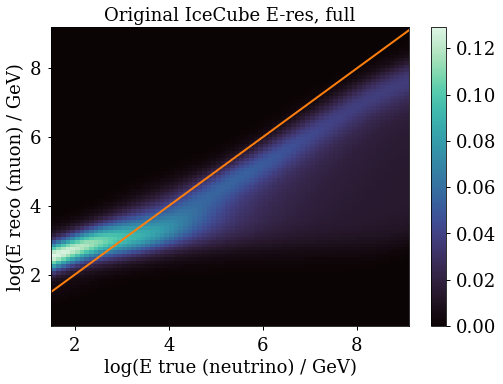

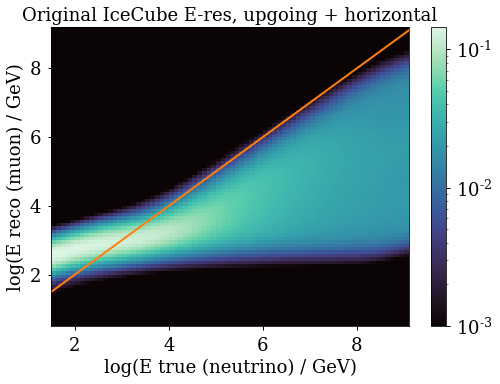

In [9]:
plt.figure()
plt.grid(False)
plt.pcolormesh(logE_bins, logE_reco_bins, normed_kvals_full)  # , norm=LogNorm(vmin=1E-9))
plt.colorbar()
plt.plot([1, 9.5], [1, 9.5], color="tab:orange")
plt.ylim(np.min(logE_reco_bins), np.max(logE_reco_bins))
plt.xlim(np.min(logE_bins), np.max(logE_bins))
plt.title("Original IceCube E-res, full")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")

plt.figure()
plt.grid(False)
plt.pcolormesh(logE_bins, logE_reco_bins, normed_kvals_up, norm=LogNorm(vmin=1E-3))
plt.colorbar()
plt.plot([1, 9.5], [1, 9.5], color="tab:orange")
plt.ylim(np.min(logE_reco_bins), np.max(logE_reco_bins))
plt.xlim(np.min(logE_bins), np.max(logE_bins))
plt.title("Original IceCube E-res, upgoing + horizontal")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")


# Parameterize the smearing matrix

In [10]:
from scipy.optimize import curve_fit

In [11]:
def double_erf(x, shift_l, shift_r, N=1): #sigma_r, , sigma_l
    sigma_r = sigma_l = 0.4
    # normalized such that it goes from 0 to N and back to 0
    return N / 4 * (erf((x - shift_l) / sigma_l) + 1) * (-erf((x - shift_r) / sigma_r) + 1)


def g_norm(x, loc, scale, N):
    return np.exp(-0.5 * ((x - loc) / scale) ** 2) * N
    # return norm.pdf(x, loc, scale) * N

def comb(x, shift_l, shift_r, N, loc, scale, n): #sigma_r, sigma_l, 
    return double_erf(x, shift_l, shift_r, N) + g_norm(x, loc, scale, n)


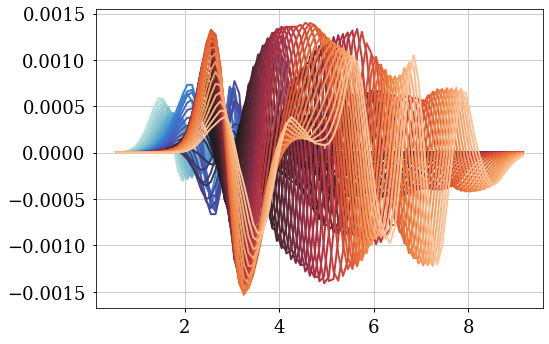

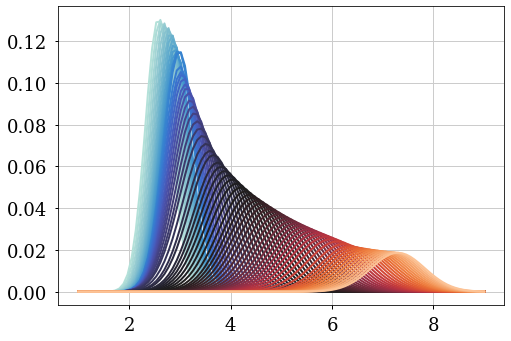

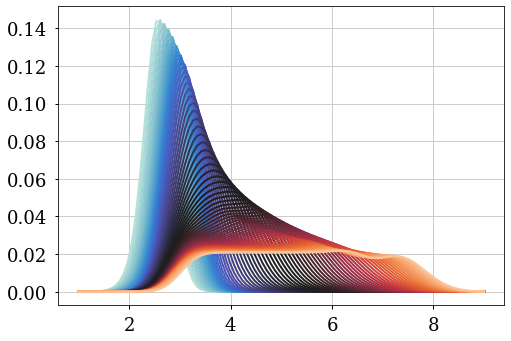

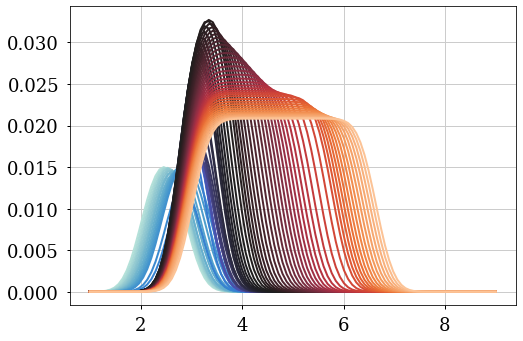

In [12]:
step = 1  # 10
sns.set_palette("tab20")
sns.set_palette("icefire", n_colors=len(logE_mids) // step + 1)


# fit_params = []
fit_params = np.zeros_like(
    logE_mids,
    dtype=[
        ("shift_l", float),
        ("shift_r", float),
        #("sigma_l", float),
        ("N", float),
        ("loc", float),
        ("scale", float),
        ("n", float),
    ],
)

xvals = np.linspace(1, 9, num=100)
for ii, et in enumerate(logE_mids):
    # find the mode of E-reco distribution in each slice of E-true
    max_ind = np.argmax(normed_kvals_up[:, ii])
    # max position
    max_loc = logE_reco_mids[max_ind]
    # save the corresponding max value
    kv_mode = normed_kvals_up[max_ind, ii]
    # estimate the flanks of the normal by referring to the mode / 2
    height = kv_mode / 2

    # selection above height, then take first and last bin
    flanks = logE_reco_mids[np.where(normed_kvals_up[:, ii] >= height)[0][[0, -1]]]
    fit_d, _ = curve_fit(
        comb,
        logE_reco_mids,
        normed_kvals_up[:, ii],
        p0=[
            flanks[0]-0.5,  # shift_l
            flanks[1],  # shift_r
            #0.5,  # sigma_l
            0.025,  # N
            flanks[1],  # loc
            0.5,  # scale
            kv_mode,  # n
        ],
        bounds=[
            (  # lower
                1,  # shift_l
                flanks[0] + 0.5,  # shift_r
                #0.001,  # sigma_l
                0.017,  # N
                1,  # loc
                0.1,  # scale
                kv_mode * 0.85,  # n
            ),
            (  # upper
                flanks[1] - 0.5,  # shift_l
                20,  # shift_r
                #5,  # sigma_l
                0.035,  # N
                9,  # loc
                10,  # scale
                0.3,  # n
            ),
        ],
    )
    fit_params[ii] = tuple(fit_d)
    #fit_params.append(fit_d)
    if ii % step == 0:
        plt.figure(-1)
        p = plt.plot(
            logE_reco_mids,
            normed_kvals_up[:, ii] - comb(logE_reco_mids, *fit_d),
        )
        plt.figure(1)
        plt.plot(
            xvals,
            g_norm(xvals, *fit_d[-3:]),
            color=p[0].get_color(),
            lw=2,
            label="normal fit",
        )
        plt.figure(2)
        plt.plot(
            xvals,
            comb(xvals, *fit_d),
            color=p[0].get_color(),
            lw=2,
            zorder=10,
            label="comb fit",
        )
        plt.figure(3)
        plt.plot(
            xvals,
            double_erf(xvals, *fit_d[:-3]),
            color=p[0].get_color(),
            lw=2,
            label="plateau fit",
        )


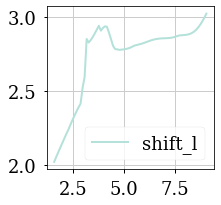

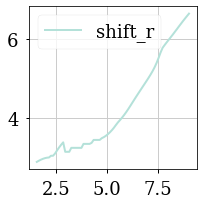

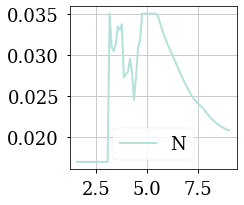

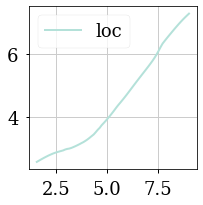

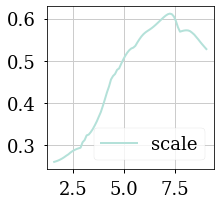

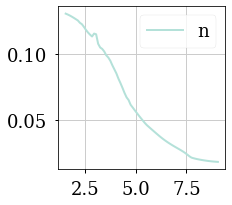

In [13]:
fit_splines = {}
smoothed_fit_params = np.zeros_like(fit_params)
for ii, n in enumerate(fit_params.dtype.names):
    plt.figure(figsize=(3,3))
    p = plt.plot(logE_mids, fit_params[n], label=n)
    fit_splines[n] = UnivariateSpline(
        logE_mids,
        fit_params[n],
        k=1,
        s=np.max(fit_params[n]) / 40, # if n == "N" else np.min(fit_params[n]) / 20,
    )
    smoothed_fit_params[n] = tuple(fit_splines[n](logE_mids))
    #plt.plot(logE_mids, fit_splines[n](logE_mids), ls="--", color="k", label="fit")
    plt.legend()
smoothed_fit_params = np.array(smoothed_fit_params)

# Artificial smearing matrix

## Best reproduction

In [14]:
artificial_2D = []
#for ii, fit_d in enumerate(smoothed_fit_params):
for ii, fit_d in enumerate(fit_params):
    artificial_2D.append(comb(logE_reco_mids, *fit_d))
artificial_2D = np.array(artificial_2D).T
artificial_2D /= np.sum(artificial_2D, axis=0)


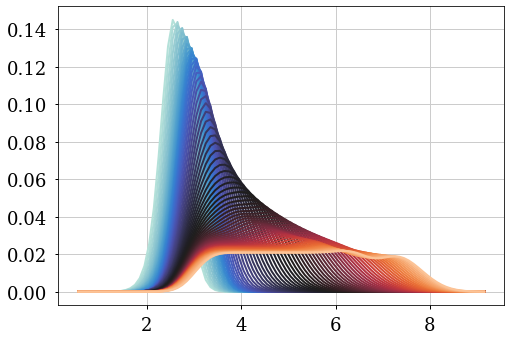

In [15]:
_ = plt.plot(logE_reco_mids, artificial_2D)

Text(0.5, 0, 'log(E true (neutrino) / GeV)')

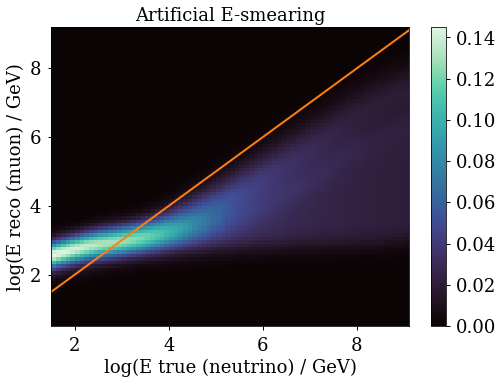

In [16]:
plt.figure()
plt.pcolormesh(logE_bins, logE_reco_bins, artificial_2D)
plt.ylim(np.min(logE_reco_bins), np.max(logE_reco_bins))
plt.xlim(np.min(logE_bins), np.max(logE_bins))
plt.plot([1, 10], [1, 10], color="tab:orange")
plt.colorbar()
plt.title("Artificial E-smearing")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")


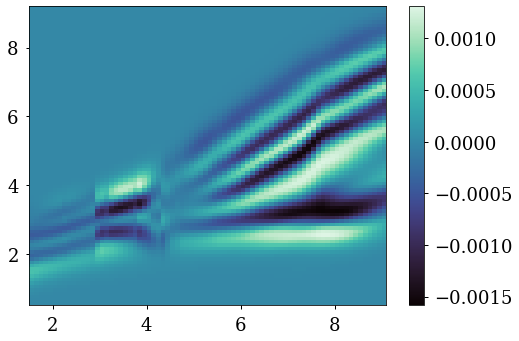

In [17]:
plt.figure()
plt.pcolormesh(logE_bins, logE_reco_bins, normed_kvals_up - artificial_2D)
plt.colorbar()

In [18]:
with open(join(BASEPATH, "local/artificial_energy_smearing_kde_up.pckl"), "wb") as f:
    pickle.dump((artificial_2D, logE_reco_bins), f)

rgi = RegularGridInterpolator((logE_reco_mids, logE_mids), artificial_2D)
with open(join(BASEPATH, "local/artificial_energy_smearing_rgi_up.pckl"), "wb") as f:
    pickle.dump(rgi, f)


## 1:1 reco reproduction

In [19]:
artificial_2D = []
for ii, fit_d in enumerate(fit_params):
    tmp_fit = fit_d.copy()
    diff = logE_mids[ii] - tmp_fit["loc"]
    tmp_fit["loc"] = logE_mids[ii]
    tmp_fit["shift_r"] += diff
    artificial_2D.append(comb(logE_reco_mids, *tmp_fit))
artificial_2D = np.array(artificial_2D).T
artificial_2D /= np.sum(artificial_2D, axis=0)


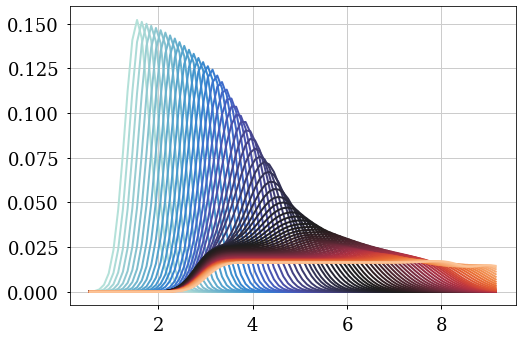

In [20]:
_ = plt.plot(logE_reco_mids, artificial_2D)

Text(0.5, 0, 'log(E true (neutrino) / GeV)')

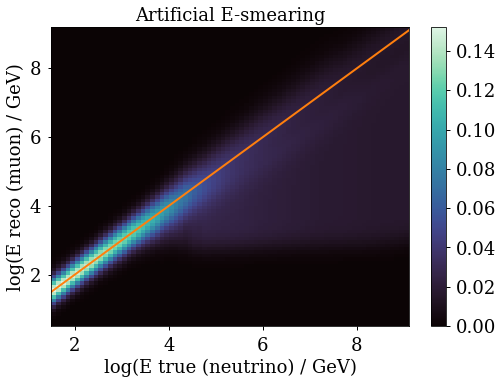

In [21]:
plt.figure()
aee, arr = np.meshgrid(logE_bins, logE_reco_bins)
plt.pcolormesh(aee, arr, artificial_2D) #, norm=LogNorm(vmin=1E-3))
plt.ylim(np.min(arr), np.max(arr))
plt.xlim(np.min(aee), np.max(aee))
plt.plot([1, 10], [1, 10], color="tab:orange")
plt.colorbar()
plt.title("Artificial E-smearing")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")


In [22]:
with open(join(BASEPATH, "local/idealized_artificial_energy_smearing_kde_up.pckl"), "wb") as f:
    pickle.dump((artificial_2D, logE_reco_bins), f)

rgi = RegularGridInterpolator((logE_reco_mids, logE_mids), artificial_2D)
with open(join(BASEPATH, "local/idealized_artificial_energy_smearing_rgi_up.pckl"), "wb") as f:
    pickle.dump(rgi, f)


## Improved artificial energy smearing

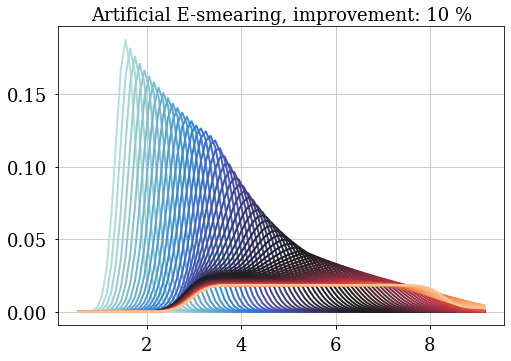

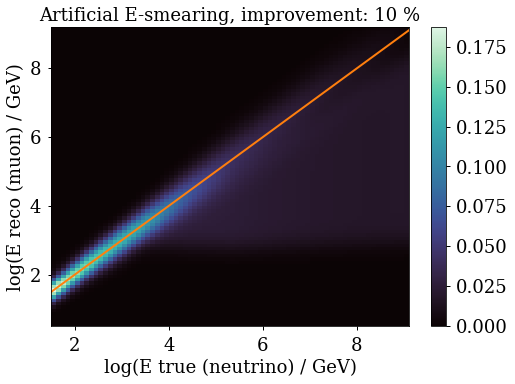

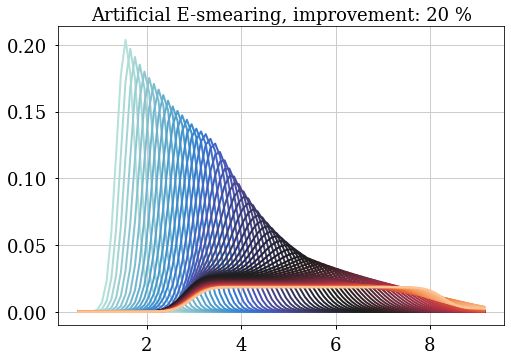

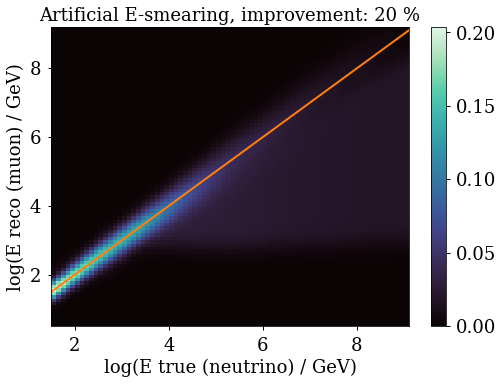

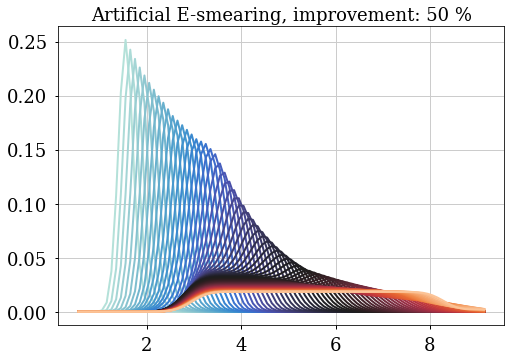

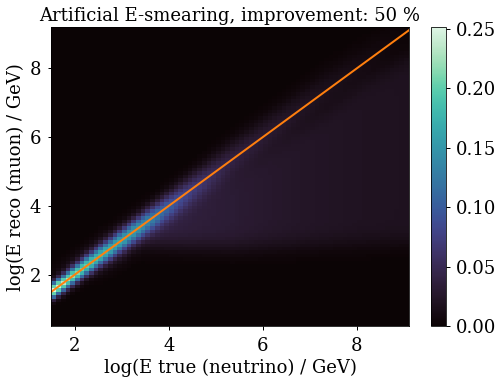

In [23]:
for ii, impro_factor in enumerate([0.1, 0.2, 0.5]):

    artificial_2D = []
    plt.figure(ii)
    plt.title(f"Artificial E-smearing, improvement: {impro_factor*100:1.0f} %")
    for jj, fit_d in enumerate(smoothed_fit_params):
        sigma = fit_d["scale"] / (1 + impro_factor)
        
        tmp_fit = fit_d.copy()
        # improve resolution
        #tmp_fit["sigma_l"] = sigma
        tmp_fit["scale"] = sigma
        tmp_fit["n"] /= (1 + impro_factor)

        # improve degeneracy
        diff = logE_mids[jj] - tmp_fit["loc"]
        tmp_fit["loc"] = logE_mids[jj]
        tmp_fit["shift_r"] += diff
        combined = comb(logE_reco_mids, *tmp_fit)
        combined /= np.sum(combined)
        artificial_2D.append(combined)
        
        plt.plot(logE_reco_mids, artificial_2D[-1])
    
    artificial_2D = np.array(artificial_2D).T
    artificial_2D /= np.sum(artificial_2D, axis=0)
    

    plt.figure(ii + 20)
    plt.pcolormesh(logE_bins, logE_reco_bins, artificial_2D)
    plt.ylim(np.min(logE_reco_bins), np.max(logE_reco_bins))
    plt.xlim(np.min(logE_bins), np.max(logE_bins))
    plt.plot([1, 10], [1, 10], color="tab:orange")
    plt.colorbar()
    plt.title(f"Artificial E-smearing, improvement: {impro_factor*100:1.0f} %")
    plt.ylabel("log(E reco (muon) / GeV)")
    plt.xlabel("log(E true (neutrino) / GeV)")

    if True:
        with open(
            join(BASEPATH, f"local/improved_{impro_factor}_artificial_energy_smearing_kde_up.pckl"),
            "wb",
        ) as f:
            pickle.dump((artificial_2D, logE_reco_bins), f)

        rgi = RegularGridInterpolator((logE_reco_mids, logE_mids), artificial_2D)
        with open(
            join(BASEPATH, f"local/improved_{impro_factor}_artificial_energy_smearing_rgi_up.pckl"),
            "wb",
        ) as f:
            pickle.dump(rgi, f)


In [24]:
raise BaseException(":)")

BaseException: :)

# UHE energy smearing

## binning

In [ ]:
bin_size = 0.1
logE_min = 7.
logE_bins_HE = np.arange(7.5, 13, step=bin_size)
logE_mids_HE = get_mids(logE_bins_HE)
logE_reco_bins_HE = np.arange(logE_min, 13.5, step=bin_size)
logE_reco_mids_HE = get_mids(logE_reco_bins_HE)
hee, hrr = np.meshgrid(logE_mids_HE, logE_reco_mids_HE)

## calculation

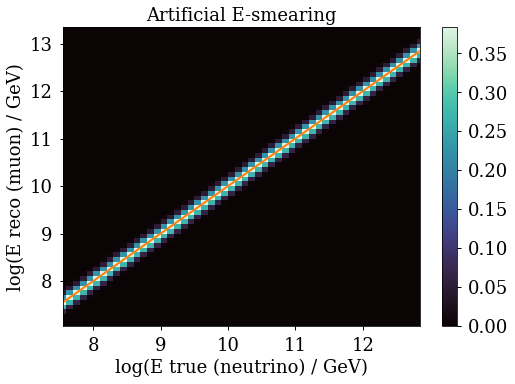

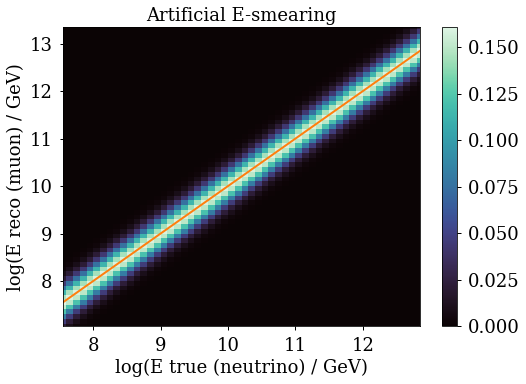

In [ ]:
for res in [0.1, 0.25]:
    dx = logE_reco_bins_HE[1] - logE_reco_bins_HE[0]
    HE_2D = []
    sigma_S = sigma_N = res  # energy resolution in log10(E)

    for e_t in logE_mids_HE:
        mu_N = e_t
        # energy resolution of the muon in log(E)
        # and slope shape
        shift_r = mu_N - sigma_S
        shift_l = mu_N + np.log10(1 - 0.2) # modeling mean inelasticity y ~ 20% at E=10⁹ GeV

        norbert = norm.pdf(logE_reco_mids_HE, loc=mu_N, scale=sigma_N)
        # normalize such that the plateau is half as high as the gauss
        siggi_norm = norm.pdf(mu_N, loc=mu_N, scale=sigma_N) / 2
        siggi = double_erf(logE_reco_mids_HE, shift_l, shift_r, sigma_S)
        siggi *= siggi_norm

        combined = siggi + norbert
        combined /= np.sum(combined * dx)  # normalize
        HE_2D.append(combined)
    HE_2D = np.array(HE_2D).T
    HE_2D /= np.sum(HE_2D, axis=0)

    plt.figure()
    plt.pcolormesh(hee, hrr, HE_2D)
    plt.ylim(np.min(hrr), np.max(hrr))
    plt.xlim(np.min(hee), np.max(hee))
    plt.plot([6, 13], [6, 13], color="tab:orange")
    plt.colorbar()
    plt.title("Artificial E-smearing")
    plt.ylabel("log(E reco (muon) / GeV)")
    plt.xlabel("log(E true (neutrino) / GeV)")

    ## save
    with open(f"../local/HE_energy_smearing_kde_{int(res*100)}-res.pckl", "wb") as f:
        pickle.dump((HE_2D, logE_reco_bins_HE), f)

    rgi = RegularGridInterpolator((logE_reco_mids_HE, logE_mids_HE), HE_2D)
    with open(f"../local/HE_energy_smearing_rgi_{int(res*100)}-res.pckl", "wb") as f:
        pickle.dump(rgi, f)

    with open(f"../local/HE_energy_smearing_2D_{int(res*100)}-res.pckl", "wb") as f:
        pickle.dump((HE_2D, logE_bins_HE, logE_reco_bins_HE), f)

# Check & Plot

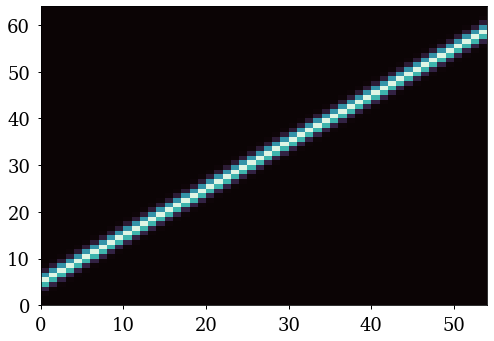

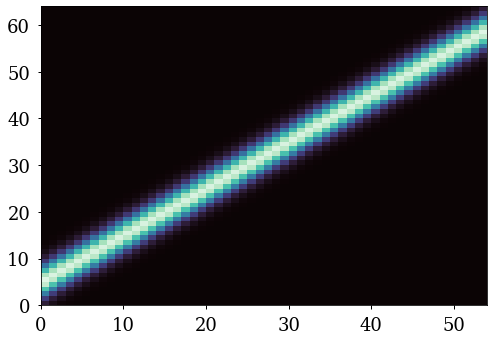

In [ ]:
# energy smearing matrix
with open("../local/HE_energy_smearing_2D_10-res.pckl", "rb") as f:
    HE_2D, logE_bins_HE, logE_reco_bins_HE = pickle.load(f)

plt.figure()
plt.pcolormesh(HE_2D)

# energy smearing matrix
with open("../local/HE_energy_smearing_2D_25-res.pckl", "rb") as f:
    HE_2D, logE_bins_HE, logE_reco_bins_HE = pickle.load(f)

plt.figure()
plt.pcolormesh(HE_2D)


In [ ]:
# energy smearing matrix
with open("../local/energy_smearing_rgi.pckl", "rb") as f:
    rgi = pickle.load(f)
# new binning
logE_reco_bins = np.arange(1.9, 9.05, step=0.05)
logE_reco_mids = get_mids(logE_reco_bins)
lge_grid, lre_grid = np.meshgrid(logE_mids, logE_reco_mids)
# baseline evaluation
normed_kvals_up = rgi((lre_grid, lge_grid))

# normalize per bin in true energy
normed_kvals_up = normed_kvals_up / np.sum(normed_kvals_up, axis=0)

# artificial, improved smearing matrix
with open("../local/improved_0.5_artificial_energy_smearing_rgi.pckl", "rb") as f:
    rgi = pickle.load(f)
artificial_normed_kvals = rgi((lre_grid, lge_grid))
# normalize per bin in true energy
artificial_normed_kvals = artificial_normed_kvals / np.sum(
    artificial_normed_kvals, axis=0
)


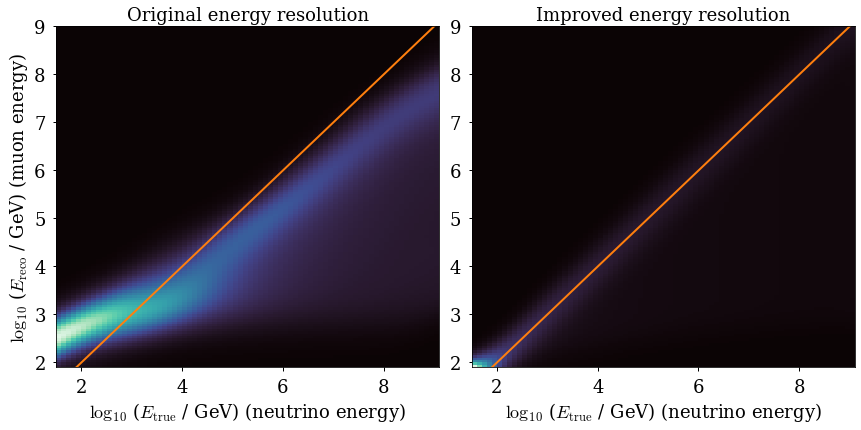

In [ ]:
# logE_mids are the same as for effective area binning
f, axes = plt.subplots(ncols=2, figsize=(12, 6))

axes[0].grid(False)
axes[0].pcolormesh(logE_bins, logE_reco_bins, normed_kvals_up)
# f.colorbar()
axes[0].plot([1, 10], [1, 10], color="tab:orange")
axes[0].set_ylim(np.min(logE_reco_bins), np.max(logE_reco_bins))
axes[0].set_xlim(np.min(logE_bins), np.max(logE_bins))
axes[0].set_title("Original energy resolution")
axes[0].set_ylabel(r"$\log_{10}$ ($E_{\rm reco}$ / GeV) (muon energy)")
axes[0].set_xlabel(r"$\log_{10}$ ($E_{\rm true}$ / GeV) (neutrino energy)")

## Artificial
axes[1].grid(False)
axes[1].pcolormesh(logE_bins, logE_reco_bins, artificial_normed_kvals)
# f.colorbar()
axes[1].plot([1, 10], [1, 10], color="tab:orange")
axes[1].set_ylim(np.min(logE_reco_bins), np.max(logE_reco_bins))
axes[1].set_xlim(np.min(logE_bins), np.max(logE_bins))
axes[1].set_title("Improved energy resolution")
# axes[1].set_ylabel(r"$\log_{10}$ ($E_{\rm reco}$ / GeV) (muon energy)")
axes[1].set_xlabel(r"$\log_{10}$ ($E_{\rm true}$ / GeV) (neutrino energy)")
f.tight_layout()
f.savefig("../plots/energy_resolution_comparison.pdf", bbox_inches="tight")
